In [2]:
import dns.query, dns.message, dns.rdatatype, dns.rdataclass
from dns.rdatatype import AAAA, A, DNSKEY, TXT
from dns.rdataclass import IN

In [3]:
ALGORITHMS = {
    5: "rsasha1", 8: "rsasha256", 10: "rsasha512",  # pdns also supports 7: "rsasha1-nsec3-sha1",
    13: "ecdsa256", 14: "ecdsa384",
    15: "ed25519", 16: "ed448",
    17: "falcon",
}
ALGORITHM_COLORS = {
    "rsasha1": "#ff0000", "rsasha256": "#dd0000", "rsasha512": "#bb0000",
    "ecdsa256": "#00ff00", "ecdsa384": "#00dd00",
    "ed25519": "#0000ff", "ed448": "#0000dd",
    "falcon": "#00ffff",
}

In [4]:
scenarios = {
    '2 A RRs with RRSIG': (A, lambda a: f'{a}.example.'),
    '1 AAAA RR with RRSIG': (AAAA, lambda a: f'{a}.example.'),
    '1 AAAA RR with RRSIG for Wildcard (NSEC)': (AAAA, lambda a: f'wildcard.{a}.example.'),
    '1 AAAA RR with RRSIG for Wildcard (NSEC3)': (AAAA, lambda a: f'wildcard.{a}3.example.'),
    '1 DNSKEY with RRSIG': (DNSKEY, lambda a: f'{a}.example.'),
    'NSEC Proof of NX': (TXT, lambda a: f'nx.{a}.example.'),
    'NSEC3 Proof of NX': (TXT, lambda a: f'nx.{a}3.example.'),
}

In [5]:
raw_data = []
for scenario, (rtype, name) in scenarios.items():
    for a in ALGORITHMS.values():
        for s in ["initial-", "new_rrsig-"]:
            
            qname = dns.name.from_text(name(s+a))
            r = dns.query.tcp(dns.message.make_query(qname, rtype, want_dnssec=True), where='127.0.0.1', port=5301)
            rwire = r.to_wire()
            raw_data.append({
                'step': s,
                'scenario': scenario,
                'algorithm': a,
                'length': len(rwire),
                'qname_count': [rwire.count(qname.split(i)[1].to_wire()) for i in range(len(qname), 1, -1)],
                'qname': qname.to_text(),
            })

In [6]:
import pandas as pd

In [7]:
data = pd.DataFrame(raw_data)
data.sample(15)

,step,scenario,algorithm,length,qname_count,qname
109,new_rrsig-,NSEC3 Proof of NX,ed448,1973,"[1, 5, 5]",nx.new_rrsig-ed4483.example.
86,initial-,NSEC Proof of NX,ecdsa256,419,"[1, 4, 4]",nx.initial-ecdsa256.example.
22,initial-,1 AAAA RR with RRSIG,ecdsa256,201,"[2, 2]",initial-ecdsa256.example.
74,initial-,1 DNSKEY with RRSIG,ed25519,219,"[2, 2]",initial-ed25519.example.
110,initial-,NSEC3 Proof of NX,falcon,1636,"[1, 3, 3]",nx.initial-falcon3.example.
3,new_rrsig-,2 A RRs with RRSIG,rsasha256,1115,"[3, 3]",new_rrsig-rsasha256.example.
37,new_rrsig-,1 AAAA RR with RRSIG for Wildcard (NSEC),rsasha512,2204,"[1, 6, 6]",wildcard.new_rrsig-rsasha512.example.
26,initial-,1 AAAA RR with RRSIG,ed25519,199,"[2, 2]",initial-ed25519.example.
33,new_rrsig-,1 AAAA RR with RRSIG for Wildcard (NSEC),rsasha1,2198,"[1, 6, 6]",wildcard.new_rrsig-rsasha1.example.
78,initial-,1 DNSKEY with RRSIG,falcon,1677,"[2, 2]",initial-falcon.example.


In [8]:
import seaborn as sns

sns.set(font_scale=2)
sns.set_style('whitegrid')

In [9]:
ALGORITHM_ORDER = list(ALGORITHM_COLORS.keys())
ALGORITHM_PALETTE = sns.color_palette([ALGORITHM_COLORS[a] for a in ALGORITHM_ORDER])

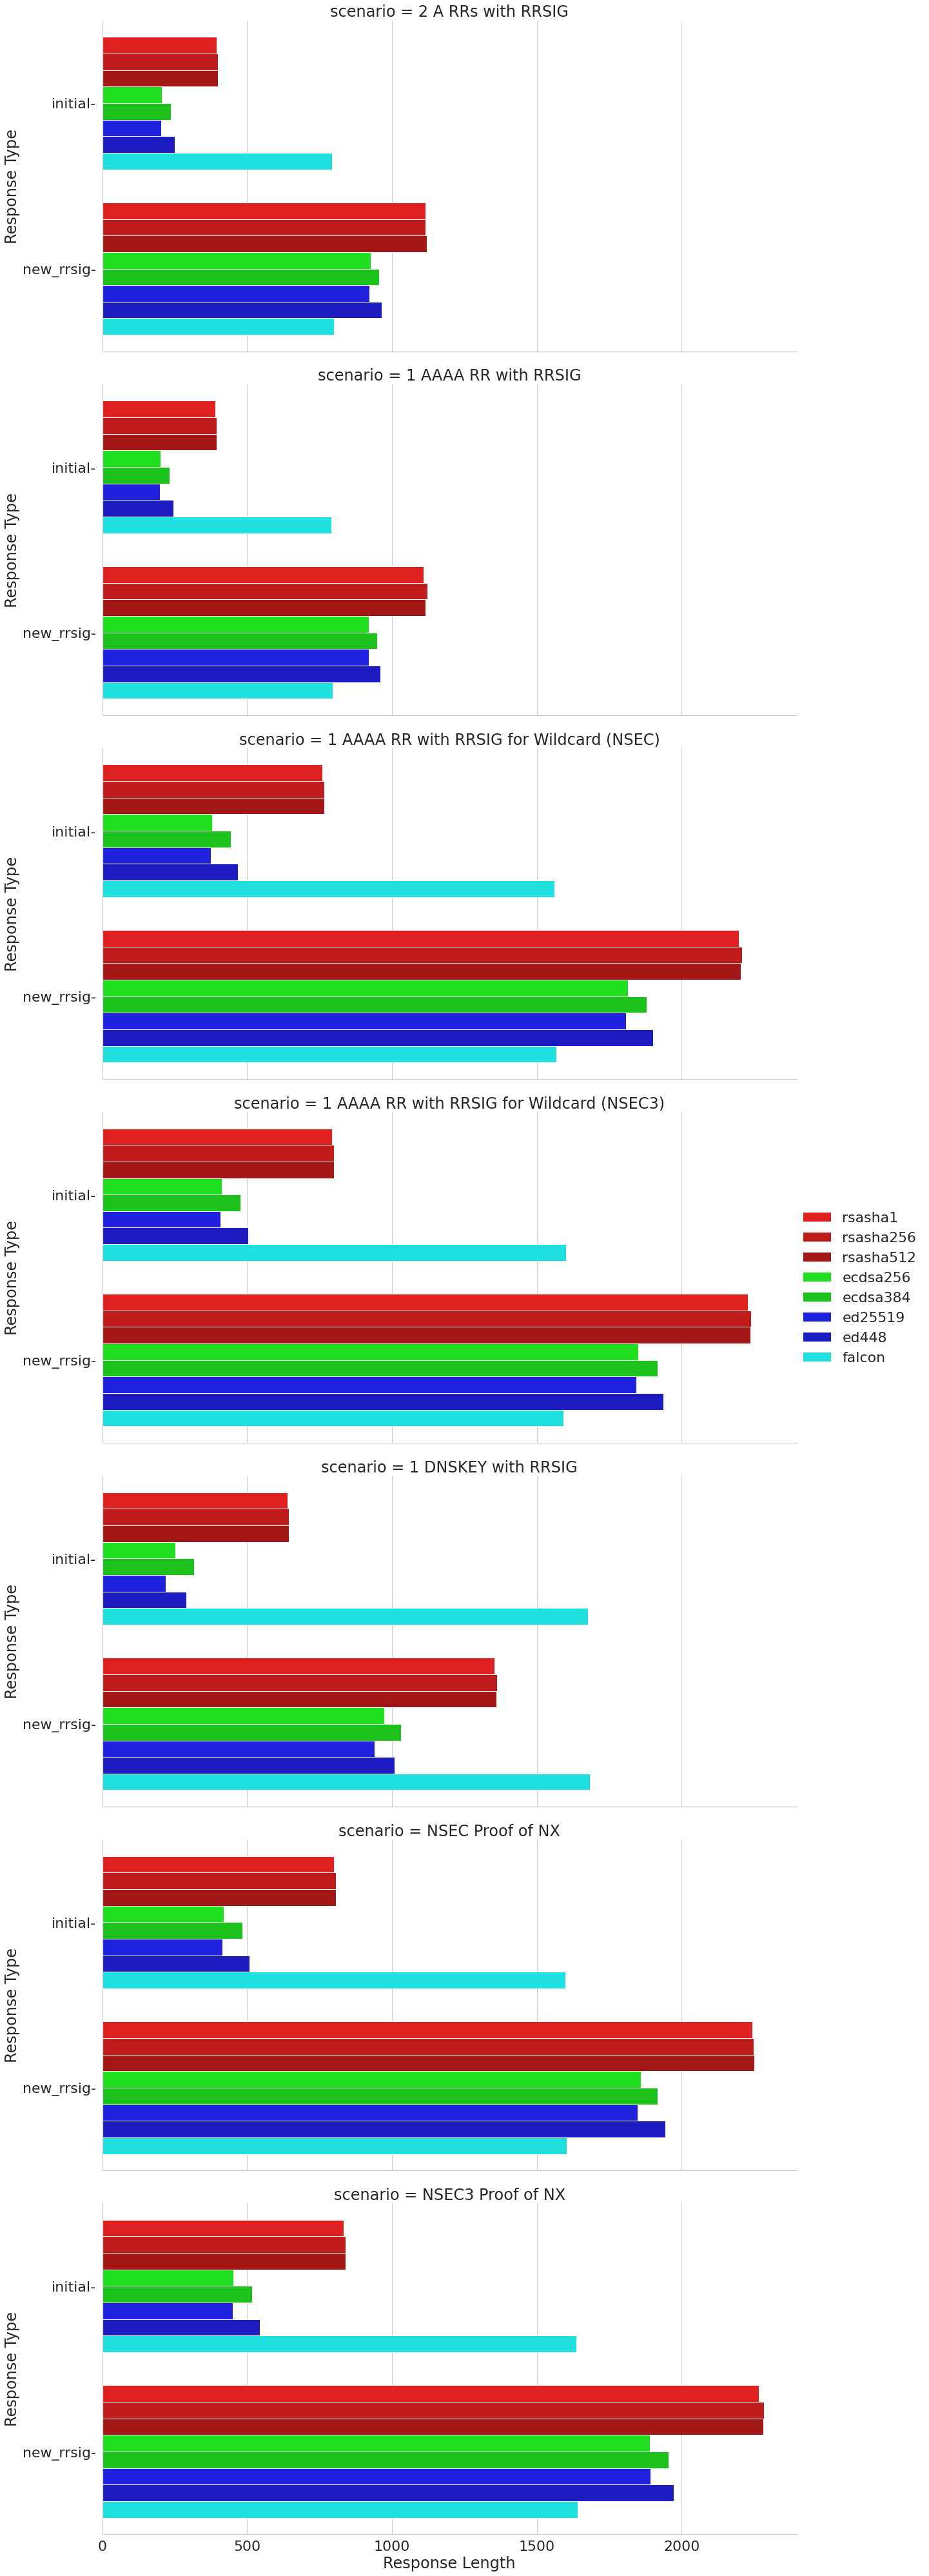

In [10]:
g = sns.catplot(
    data=data,
    row='scenario',
    y='step',
    hue='algorithm', hue_order=ALGORITHM_ORDER, palette=ALGORITHM_PALETTE,
    x='length',
    kind='bar',
    height=8,
    aspect=18/8,
)
g.set(
    ylabel='Response Type',
    xlabel='Response Length',
)
g.legend.set_title('')
g.savefig('nils.pdf')